# Import packages and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
import random

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
d_icd = pd.read_csv("/content/gdrive/My Drive/COMP 565/D_ICD_DIAGNOSES.csv.gz", compression='gzip')
d_icd

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,55,0065,Amebic brain abscess,Amebic brain abscess
1,56,0066,Amebic skin ulceration,Amebic skin ulceration
2,57,0068,Amebic infection NEC,Amebic infection of other sites
3,58,0069,Amebiasis NOS,"Amebiasis, unspecified"
4,59,0070,Balantidiasis,Balantidiasis
...,...,...,...,...
14562,10053,V1368,"Hx-cong malform-skin,ms",Personal history of (corrected) congenital mal...
14563,11201,79508,Unsat cerv cytlogy smear,Unsatisfactory cervical cytology smear
14564,11202,79509,Abn pap cervix HPV NEC,Other abnormal Papanicolaou smear of cervix an...
14565,11203,79510,Abn gland pap smr vagina,Abnormal glandular Papanicolaou smear of vagina


In [4]:
mimic3 = pd.read_csv("/content/gdrive/My Drive/COMP 565/MIMIC3_DIAGNOSES_ICD_subset.csv.gz", compression='gzip')
mimic3["SUBJECT_ID"] = mimic3["SUBJECT_ID"].astype(str)
mimic3["ICD9_CODE"] = mimic3["ICD9_CODE"].astype(str)
mimic3 # d, i

,SUBJECT_ID,ICD9_CODE
0,17843,2851
1,10152,389
2,15311,4280
3,45434,5070
4,32229,51881
...,...,...
995,26042,5849
996,83875,486
997,50391,29410
998,25030,78039


In [5]:
# unique subject id
subject_id_uni = mimic3["SUBJECT_ID"].unique()
subject_id_uni = pd.DataFrame(subject_id_uni, columns=["subject_id"])
# unique icd9_code
icd_uni = mimic3["ICD9_CODE"].unique()
icd_uni = pd.DataFrame(icd_uni, columns=["icd"])

In [6]:
subject_id_uni # d

,subject_id
0,17843
1,10152
2,15311
3,45434
4,32229
...,...
684,13339
685,59761
686,1338
687,26042


In [7]:
icd_uni # w

,icd
0,2851
1,389
2,4280
3,5070
4,51881
...,...
382,85205
383,5579
384,85305
385,34839


# 1 Implementing collapsed Gibbs sampling LDA

## Initializing the parameters

In [8]:
K = 5 # number of topics
D = len(mimic3["SUBJECT_ID"].unique()) # number of documents/patients, 689
M = len(mimic3["ICD9_CODE"].unique()) # size of vocabulary/icd codes, 387
alpha = 1
beta = 0.001

In [9]:
# Count matrix
n_dk = np.zeros((D, K)) # theta_d, 689 * 5
n_wk = np.zeros((M, K)) # phi, 387 * 5
z_id = np.zeros((len(mimic3))) # [0, ..., 0] length of 1000
n_k = np.zeros((K)) # keep track of the number for each topic, length = 5

In [10]:
# initialize the topic assignments to each document
for index, row in mimic3.iterrows():
  # assign the topic randomly
  topic = index % K
  z_id[index] = topic
  
  # find the index correspond to n_dk, n_wk
  subject_id = row["SUBJECT_ID"]
  d = subject_id_uni.index[subject_id_uni["subject_id"]==subject_id][0]
  n_dk[d, topic] += 1

  icd = row["ICD9_CODE"]
  w = icd_uni.index[icd_uni["icd"]==icd][0]
  n_wk[w, topic] += 1

  n_k[topic] += 1

In [11]:
n_k

array([200., 200., 200., 200., 200.])

In [12]:
n_wk # 387 * 5

array([[ 1.,  1.,  1.,  1.,  3.],
       [ 3.,  5.,  4.,  2.,  0.],
       [11.,  2.,  5.,  4.,  5.],
       ...,
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [13]:
n_dk # 689 * 5

array([[2., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [14]:
z_id.shape

(1000,)

## Implement the algorithm

In [15]:
def LDA(df, n_k = n_k, z_id = z_id, n_wk = n_wk, n_dk = n_dk, niter = 100):
  np.random.seed(100)
  for i in range(niter):
    for index, row in df.iterrows():
      # get the topic for the current patient
      topic_z = int(z_id[index])
      subject_id = row["SUBJECT_ID"]
      d = subject_id_uni.index[subject_id_uni["subject_id"]==subject_id][0]
      icd = row["ICD9_CODE"]
      w = icd_uni.index[icd_uni["icd"]==icd][0]

      # find all n^(-(i, d))
      n_dk[d, topic_z] -= 1
      n_wk[w, topic_z] -= 1
      n_k[topic_z] -= 1

      # calculate gamma_idk
      term1 = alpha + n_dk[d,]
      term2 = (beta + n_wk[w,]) / (M*beta + n_k)
      gamma_idk = term1 * term2

      # normalize and update z
      gamma_idk = gamma_idk / gamma_idk.sum()
      new_topic_z = np.random.multinomial(1, gamma_idk).argmax()

      # update n_dk and n_wk
      z_id[index] = new_topic_z
      n_dk[d, new_topic_z] += 1
      n_wk[w, new_topic_z] += 1
      n_k[new_topic_z] += 1

    print("Iteration: " + str(i+1) + " finished")


In [16]:
LDA(df=mimic3)

Iteration: 1 finished
Iteration: 2 finished
Iteration: 3 finished
Iteration: 4 finished
Iteration: 5 finished
Iteration: 6 finished
Iteration: 7 finished
Iteration: 8 finished
Iteration: 9 finished
Iteration: 10 finished
Iteration: 11 finished
Iteration: 12 finished
Iteration: 13 finished
Iteration: 14 finished
Iteration: 15 finished
Iteration: 16 finished
Iteration: 17 finished
Iteration: 18 finished
Iteration: 19 finished
Iteration: 20 finished
Iteration: 21 finished
Iteration: 22 finished
Iteration: 23 finished
Iteration: 24 finished
Iteration: 25 finished
Iteration: 26 finished
Iteration: 27 finished
Iteration: 28 finished
Iteration: 29 finished
Iteration: 30 finished
Iteration: 31 finished
Iteration: 32 finished
Iteration: 33 finished
Iteration: 34 finished
Iteration: 35 finished
Iteration: 36 finished
Iteration: 37 finished
Iteration: 38 finished
Iteration: 39 finished
Iteration: 40 finished
Iteration: 41 finished
Iteration: 42 finished
Iteration: 43 finished
Iteration: 44 finish

## Normalize the final ICDs-by-topics and the patients-by-topics matrix

In [17]:
theta = np.zeros((D, K)) # theta_d, 689 * 5
phi = np.zeros((M, K)) # phi, 387 * 5

In [18]:
for w in range(M):
  phi[w,] = (beta+n_wk[w,])/(M*beta + n_k)

In [19]:
for d in range(D):
  theta[d,] = (alpha + n_dk[d,]) / (K*alpha + n_dk[d,].sum())

In [20]:
phi

array([[5.01537212e-06, 5.70167686e-06, 3.32767709e-02, 4.57902714e-06,
        5.04065287e-06],
       [5.01537212e-06, 7.98291778e-02, 4.75314539e-06, 4.57902714e-06,
        5.04065287e-06],
       [1.35420062e-01, 5.70167686e-06, 4.75314539e-06, 4.57902714e-06,
        5.04065287e-06],
       ...,
       [5.01537212e-06, 5.70737854e-03, 4.75314539e-06, 4.57902714e-06,
        5.04065287e-06],
       [5.01537212e-06, 5.70167686e-06, 4.75314539e-06, 4.57902714e-06,
        5.04569352e-03],
       [5.01537212e-06, 5.70737854e-03, 4.75314539e-06, 4.57902714e-06,
        5.04065287e-06]])

In [21]:
theta

array([[0.375     , 0.125     , 0.25      , 0.125     , 0.125     ],
       [0.14285714, 0.28571429, 0.14285714, 0.28571429, 0.14285714],
       [0.33333333, 0.16666667, 0.16666667, 0.16666667, 0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.33333333, 0.16666667, 0.16666667],
       [0.16666667, 0.16666667, 0.33333333, 0.16666667, 0.16666667],
       [0.16666667, 0.33333333, 0.16666667, 0.16666667, 0.16666667]])

# 2 Visualizing the top ICD codes under each topic

In [22]:
phi_df = pd.DataFrame(phi.tolist(), columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
phi_df["ICD9_CODE"] = icd_uni["icd"]

In [23]:
# Join the ICD9_CODE and short name
phi_df = pd.merge(phi_df, d_icd, on="ICD9_CODE", how='left')
phi_df["ICD9-SHORT"] = phi_df["ICD9_CODE"] + "-" + phi_df["SHORT_TITLE"]

In [24]:
phi_df= phi_df[["ICD9-SHORT", "topic1", "topic2", "topic3", "topic4", "topic5"]]

In [25]:
phi_df

,ICD9-SHORT,topic1,topic2,topic3,topic4,topic5
0,2851-Ac posthemorrhag anemia,0.000005,0.000006,0.033277,0.000005,0.000005
1,NaN,0.000005,0.079829,0.000005,0.000005,0.000005
2,4280-CHF NOS,0.135420,0.000006,0.000005,0.000005,0.000005
3,5070-Food/vomit pneumonitis,0.065205,0.000006,0.000005,0.000005,0.000005
4,51881-Acute respiratry failure,0.000005,0.000006,0.038030,0.000005,0.000005
...,...,...,...,...,...,...
382,85205-Subarach hem-deep coma,0.000005,0.000006,0.000005,0.000005,0.005046
383,5579-Vasc insuff intest NOS,0.000005,0.000006,0.000005,0.004584,0.000005
384,85305-Brain hem NEC-deep coma,0.000005,0.005707,0.000005,0.000005,0.000005
385,34839-Encephalopathy NEC,0.000005,0.000006,0.000005,0.000005,0.005046


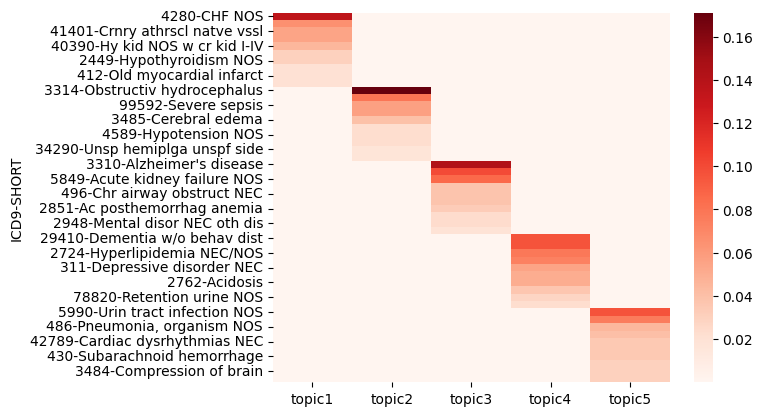

In [26]:
topic1 = phi_df.nlargest(10, "topic1")
topic2 = phi_df.nlargest(10, "topic2")
topic3 = phi_df.nlargest(10, "topic3")
topic4 = phi_df.nlargest(10, "topic4")
topic5 = phi_df.nlargest(10, "topic5")

icd_topic_df = pd.concat([topic1, topic2, topic3, topic4, topic5], axis = 0)
icd_topic_df = icd_topic_df.fillna(0)
icd_topic_df.set_index('ICD9-SHORT', inplace = True)

# Plot the heatmap
ax = heatmap(icd_topic_df, cmap="Reds", linecolor="white")
plt.show()

# 3 Correlating topics with the target ICD codes

In [27]:
theta_df = pd.DataFrame(theta.tolist(), columns = ["topic1", "topic2", "topic3", "topic4", "topic5"])
theta_df["SUBJECT_ID"] = subject_id_uni["subject_id"]

In [28]:
theta_df = pd.merge(theta_df, mimic3, on="SUBJECT_ID", how='left')
theta_df["icd331"] = np.where(theta_df["ICD9_CODE"].str.startswith("331"), 1.0, 0.0)
theta_df["icd332"] = np.where(theta_df["ICD9_CODE"].str.startswith("332"), 1.0, 0.0)
theta_df["icd340"] = np.where(theta_df["ICD9_CODE"].str.startswith("340"), 1.0, 0.0)

In [29]:
corr_matrix = np.zeros((5, 3))
icd = ["icd331", "icd332", "icd340"]

In [30]:
for i in range(5):
  for j in range(3):
    corr_matrix[i, j] = theta_df[str("topic"+str(i+1))].corr(theta_df[icd[j]])

In [31]:
corr_df = pd.DataFrame(corr_matrix, columns =["icd331", "icd332", "icd340"], index=["topic1", "topic2", "topic3", "topic4", "topic5"])

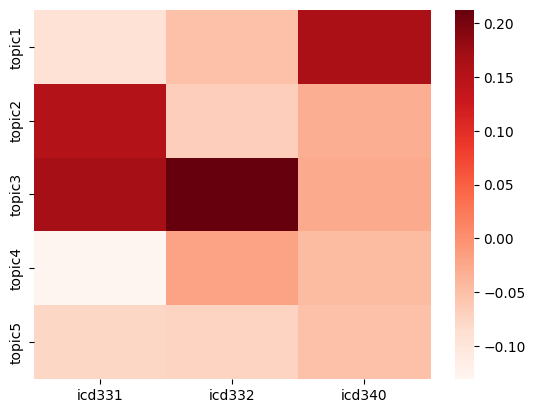

In [32]:
ax=heatmap(corr_df, cmap="Reds", linecolor="white")
plt.show()

# 4 Visualizing patient topic mixtures

In [33]:
topic1 = theta_df.nlargest(100, "topic1")
topic2 = theta_df.nlargest(100, "topic2")
topic3 = theta_df.nlargest(100, "topic3")
topic4 = theta_df.nlargest(100, "topic4")
topic5 = theta_df.nlargest(100, "topic5")

icd_topic_df = pd.concat([topic1, topic2, topic3, topic4, topic5], axis = 0)
icd_topic_df = icd_topic_df.fillna(0)

In [34]:
topics_df = icd_topic_df[["SUBJECT_ID", "topic1", "topic2", "topic3", "topic4", "topic5"]]
icds_df = icd_topic_df[["SUBJECT_ID", "icd331", "icd332", "icd340"]]
topics_df = topics_df.set_index('SUBJECT_ID')
icds_df = icds_df.set_index('SUBJECT_ID')

<Axes: ylabel='SUBJECT_ID'>

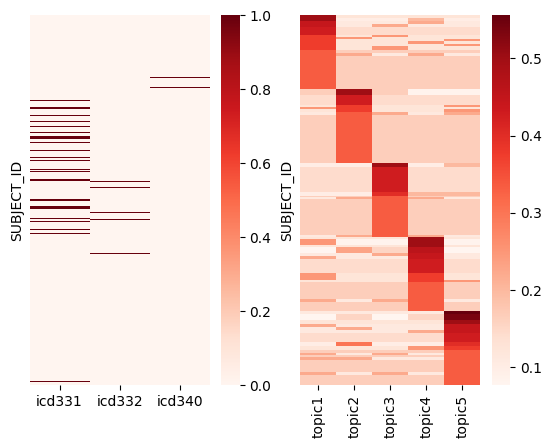

In [35]:
# Plot the heatmap
plt.subplot(1, 2, 1)
heatmap(icds_df, cmap="Reds", linecolor="white",yticklabels=False)
plt.subplot(1, 2, 2)
heatmap(topics_df, cmap="Reds", linecolor="white", yticklabels=False)